<a href="https://colab.research.google.com/github/razzlestorm/DS-Unit-2-Regression-Classification/blob/master/module3/Jerimiah_Willhite_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [216]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [402]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

df.shape

(23040, 21)

In [390]:
#Checking to see what kind of buildings are here
df['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
22 STORE BUILDINGS                             288
05 TAX CLASS 1 VACANT LAND                     288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
43 CONDO OFFICE BUILDINGS      

In [0]:
#Convert Sale Date to datetime format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [0]:
#changing data for year_built, getting rid of zeroes in year built, THEN DROPPING THEM BECAUSE THAT'S HOW WE ROLL. NO SPOOKY OLD HOUSES IN OUR DATASET
df = df[(df['YEAR_BUILT'].notnull() == True) & (df['YEAR_BUILT'] != 0.0)]

#also getting rid prices of outliers and focusing on residential units, with some bigger buildings thrown in
df = df.groupby('BUILDING_CLASS_CATEGORY').filter(lambda x: len(x)>105)
df = df[df['SALE_PRICE'] < 5000000]
df = df[df['SALE_PRICE'] > 1]
df = df[df['ZIP_CODE'] != 0]
df = df[df['YEAR_BUILT'] > 1895]
#gross square feet too much! Taking some out
df = df[df['GROSS_SQUARE_FEET'] < 15000]

In [405]:
#Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#df['SALE_DATE'].dt.month.value_counts()
cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE_DATE'] < cutoff]
test = df[df['SALE_DATE'] >= cutoff]

train.shape, test.shape

((10787, 21), (2999, 21))

In [406]:
#Checking unique value counts and creating list of cols I'm interested in.
#Also potentially interested in APARTMENT_NUMBER to see if apartments with 8 go for higher and 4 go for lower (Chinese superstition).

for col in train.columns:
    print(f'{col} Uniques:')
    print(df[col].nunique())

to_examine = ['BOROUGH', 'ZIP_CODE', 'GROSS_SQUARE_FEET', 'YEAR_BUILT']

BOROUGH Uniques:
5
NEIGHBORHOOD Uniques:
246
BUILDING_CLASS_CATEGORY Uniques:
15
TAX_CLASS_AT_PRESENT Uniques:
10
BLOCK Uniques:
6137
LOT Uniques:
1086
EASE-MENT Uniques:
0
BUILDING_CLASS_AT_PRESENT Uniques:
53
ADDRESS Uniques:
13714
APARTMENT_NUMBER Uniques:
963
ZIP_CODE Uniques:
182
RESIDENTIAL_UNITS Uniques:
23
COMMERCIAL_UNITS Uniques:
13
TOTAL_UNITS Uniques:
29
LAND_SQUARE_FEET Uniques:
2299
GROSS_SQUARE_FEET Uniques:
2614
YEAR_BUILT Uniques:
120
TAX_CLASS_AT_TIME_OF_SALE Uniques:
3
BUILDING_CLASS_AT_TIME_OF_SALE Uniques:
50
SALE_PRICE Uniques:
3212
SALE_DATE Uniques:
110


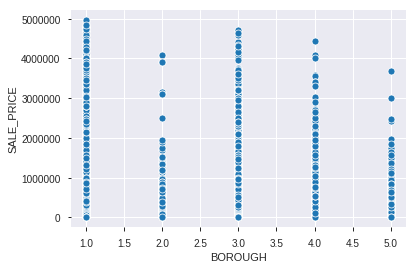

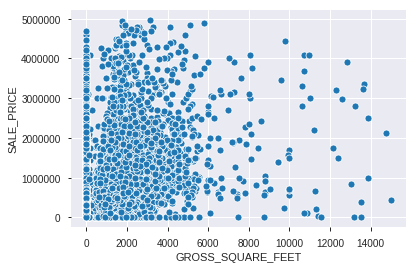

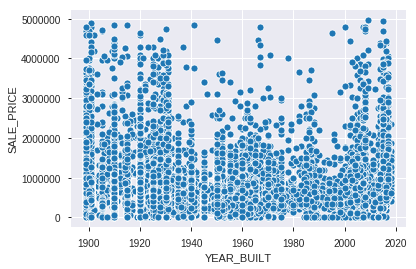

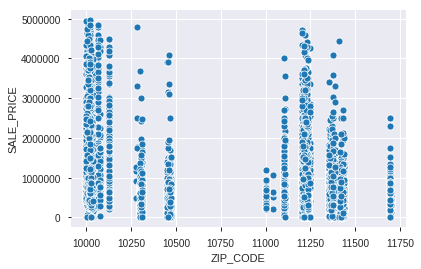

In [407]:
#Do exploratory visualizations with Seaborn.
for col in sorted(train.columns):
    if col in to_examine:
        sns.scatterplot(x=col, y='SALE_PRICE', data = train,)
        plt.show()

In [408]:
#But also look at plotly scatter plots! So pretty! 

for col in sorted(train.columns):
    if col in to_examine:
        fig = go.Figure(data=go.Scattergl(
        x= train[col],
        y = train['SALE_PRICE'],
        mode='markers',
        marker=dict(
        size=10,
        color=train['SALE_PRICE'],
        colorscale='Portland', # one of plotly colorscales
        showscale=True
    )
))
        fig.update_layout(title=col)
        fig.show()




In [409]:
#Do one-hot encoding of categorical features.
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,10787,10787,10787,10787,10787,1983,10763,10787,10787
unique,245,15,10,50,10735,793,2013,49,84
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,D4,205-15 113TH AVENUE,4,0,D4,2019-01-31 00:00:00
freq,306,2681,5370,2284,4,44,4066,2284,295
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [410]:
#Do feature selection with SelectKBest.
train_sub = train.select_dtypes(['number', 'float64']).dropna(axis='columns')
test_sub = test.select_dtypes(['number', 'float64']).dropna(axis='columns')
assert all(train_sub.columns == test_sub.columns)

target = 'SALE_PRICE'
features = train_sub.columns.drop(target)
X_train = train_sub[features]
y_train = train_sub[target]
X_test = test_sub[features]
y_test = test_sub[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10787, 10), (10787,), (2999, 10), (2999,))

In [411]:
train.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                         10787
BUILDING_CLASS_AT_PRESENT             0
ADDRESS                               0
APARTMENT_NUMBER                   8804
ZIP_CODE                              0
RESIDENTIAL_UNITS                     0
COMMERCIAL_UNITS                      0
TOTAL_UNITS                           0
LAND_SQUARE_FEET                     24
GROSS_SQUARE_FEET                     0
YEAR_BUILT                            0
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [412]:
X_train.head()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
65,1,691,1130,10011.0,1.0,0.0,1.0,1077.0,2013.0,2
66,1,1347,18,10022.0,0.0,0.0,0.0,0.0,1960.0,2
67,1,1491,62,10075.0,0.0,0.0,0.0,0.0,1925.0,2


In [418]:
#We're selecting only the best features folks, believe me.
#Fit a linear regression model with multiple features.
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((10787, 3), (2999, 3))

In [419]:
#checking features selected:

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]

print('Features selected: ')
for name in selected_names:
    print(name)

Features selected: 
BOROUGH
BLOCK
GROSS_SQUARE_FEET


In [420]:
#Get mean absolute error for the test set.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae=mean_absolute_error(y_test, y_pred)
print(f'MAE of Test = {mae:,.0f}')

MAE of Test = 428,769


In [421]:
#Now try with r squared and r squared adjust
#computer with statsmodel
#WE will add intercept manually

import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)

0.2502314607857913 0.25002286339938284


In [422]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} ]\n')

1 features
Test MAE: $486,535 ]

2 features
Test MAE: $477,898 ]

3 features
Test MAE: $428,769 ]

4 features
Test MAE: $428,492 ]

5 features
Test MAE: $423,109 ]

6 features
Test MAE: $424,839 ]

7 features
Test MAE: $425,553 ]

8 features
Test MAE: $425,655 ]

9 features
Test MAE: $425,667 ]

10 features
Test MAE: $425,514 ]

